In [1]:
import pandas as pd
import numpy as np
import os
import pydicom
from PIL import Image
from sklearn.model_selection import train_test_split

In [2]:
# Load the CSV file
data_path = 'U:/GitHub/AI-ethnicity-med-image/data/NLST_CT_withPID.csv'
df = pd.read_csv(data_path)

In [3]:
# Define the mapping for the selected categories
race_mapping = {
    1: "White",
    2: "Black or African-American",
    3: "Asian",
    4: "American Indian or Alaskan Native",
    5: "Native Hawaiian or Other Pacific Islander"
}

# Map the 'Patient Race' column to the corresponding strings
df['Patient Race'] = df['Patient Race'].map(race_mapping)

# Drop rows where 'Patient Race' is NaN
df_cleaned = df.dropna(subset=['Patient Race'])

# Ensure unique patients
unique_patients = df_cleaned.drop_duplicates(subset=['Subject ID'])

# Sample a maximum number of images per patient (1 image per unique patient)
sampled_df = unique_patients.sample(n=10000, random_state=42)

In [4]:
print("Shape of the cleaned DataFrame:", sampled_df.shape)

Shape of the cleaned DataFrame: (25826, 16)


In [5]:
# Convert the 'Patient Race' to integer labels
label_mapping = {
    "White": 0,
    "Black or African-American": 1,
    "Asian": 2,
    "American Indian or Alaskan Native": 3,
    "Native Hawaiian or Other Pacific Islander": 4
}

# Map the categorical race labels to numerical values
sampled_df['Race_Label'] = sampled_df['Patient Race'].map(label_mapping)

# Split the data into training and validation sets (stratified by race)
X_train, X_val, y_train, y_val = train_test_split(
    sampled_df['File Location'],  # File paths to the DICOM images
    sampled_df['Race_Label'],     # Race labels as integers
    test_size=0.2, 
    stratify=sampled_df['Race_Label'], 
    random_state=42
)

In [6]:
current_path = os.getcwd()
print(current_path)

u:\GitHub\AI-ethnicity-med-image


In [8]:
# Change to current directory
os.chdir(r'E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT')
print(os.getcwd())

E:\Data\NLST\Radiology CT Images\manifest-NLST_allCT


In [9]:
# Preprocess images for model input
def preprocess_images(file_paths, labels):
    image_data = []
    processed_labels = []
    for file_path, label in zip(file_paths, labels):
        dicom_folder = file_path  # Path to the folder containing DICOM images
        dicom_files = [f for f in os.listdir(dicom_folder) if f.endswith('.dcm')]  # List DICOM files
        
        if dicom_files:
            for dicom_file in dicom_files:
                dicom_path = os.path.join(dicom_folder, dicom_file)
                ds = pydicom.dcmread(dicom_path)  # Read the DICOM file
                img_array = ds.pixel_array  # Extract pixel array

                # Normalize the image
                img_array = img_array / np.max(img_array)  # Normalize to [0, 1]

                # Resize the image
                img = Image.fromarray(img_array)  # Convert to PIL image
                img = img.resize((224, 224))  # Resize to 224x224 pixels
                img_array_resized = np.array(img)  # Convert back to numpy array
                
                image_data.append(img_array_resized)
                processed_labels.append(label)  # Append the corresponding label
    
    return np.array(image_data), np.array(processed_labels)

In [9]:
# Preprocess images for training and validation sets
X_train_images, y_train_labels = preprocess_images(X_train, y_train)
X_val_images, y_val_labels = preprocess_images(X_val, y_val)

# Expand dimensions to match the input shape of the EfficientNet model
X_train_images = np.expand_dims(X_train_images, axis=-1)
X_val_images = np.expand_dims(X_val_images, axis=-1)

# Repeat the channel to make it 3-channel (RGB) to be compatible with EfficientNet
X_train_images = np.repeat(X_train_images, 3, axis=-1)
X_val_images = np.repeat(X_val_images, 3, axis=-1)


In [10]:
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [12]:
# Load the pre-trained EfficientNetB0 model without the top layer
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = False

# Add custom layers on top of the pre-trained model
x = base_model.output
x = Flatten()(x)  # Flatten the output
x = Dense(512, activation='relu')(x)  # Fully connected layer
x = Dropout(0.5)(x)  # Dropout for regularization
num_classes = 5
output = Dense(num_classes, activation='softmax')(x)  # Output layer with softmax activation for multiclass classification

In [13]:
# Create the complete model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the preprocessed images
history = model.fit(X_train_images, y_train_labels, validation_data=(X_val_images, y_val_labels), epochs=10, batch_size=32)

# Save the model
model.save('ethnicity_classification_model.h5')

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\keras\optimizer_v2\optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Epoch 1/10
1060/1060 [==============================] - 1855s 2s/step - loss: 0.8307 - accuracy: 0.9203 - val_loss: 0.4151 - val_accuracy: 0.9035
Epoch 2/10
1060/1060 [==============================] - 2077s 2s/step - loss: 0.3589 - accuracy: 0.9269 - val_loss: 0.3667 - val_accuracy: 0.9035
Epoch 3/10
1060/1060 [==============================] - 2052s 2s/step - loss: 0.3402 - accuracy: 0.9275 - val_loss: 0.3508 - val_accuracy: 0.9035
Epoch 4/10
1060/1060 [==============================] - 2058s 2s/step - loss: 0.3229 - accuracy: 0.9275 - val_loss: 0.3688 - val_accuracy: 0.9035
Epoch 5/10
1060/1060 [==============================] - 2055s 2s/step - loss: 0.3107 - accuracy: 0.9275 - val_loss: 0.3543 - val_accuracy: 0.9035
Epoch 6/10
1060/1060 [==============================] - 2051s 2s/step - loss: 0.3062 - accuracy: 0.9275 - val_loss: 0.3480 - val_accuracy: 0.9035
Epoch 7/10
1060/1060 [==============================] - 2052s 2s/step - loss: 0.3050 - accuracy: 0.9275 - val_loss: 0.3445 -

c:\Users\yuting.tseng\AppData\Local\anaconda3\envs\dicom_env\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Class distribution after cleaning:
White                                        921
Black or African-American                     52
Asian                                         17
Native Hawaiian or Other Pacific Islander      7
American Indian or Alaskan Native              3
Name: Patient Race, dtype: int64


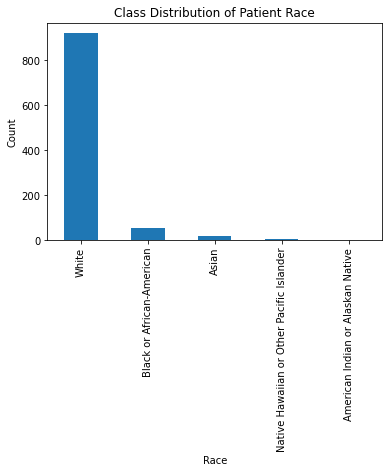

In [16]:
import matplotlib.pyplot as plt
# Check class distribution
print("Class distribution after cleaning:")
print(sampled_df['Patient Race'].value_counts())

# Plot class distribution
sampled_df['Patient Race'].value_counts().plot(kind='bar', title="Class Distribution of Patient Race", xlabel="Race", ylabel="Count")
plt.show()
